In [22]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from dateutil.relativedelta import relativedelta
import mapclassify
from collections import defaultdict
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

import nxviz as nv
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

idx = pd.IndexSlice

# -- base paths
basepath = Path.home().joinpath("Documents", "data")
cnespath = basepath.joinpath("opendatasus", "cnes")
geopath = basepath.joinpath("shapefilesceqgis")
simpath = basepath.joinpath("sim", "DBF")
gmlpath = basepath.joinpath("redes_aih")
ccapath = basepath.joinpath("cca_erneson")
figpath = gmlpath.joinpath("doc_final")
gml_output = gmlpath.joinpath("novo_completo")

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

pop_2022_ibge = pd.read_parquet(geopath.joinpath("pop_ce_2022_ibge.parquet"))
geodata_df = geodata_df.merge(pop_2022_ibge)

name_macro = {
    1: "Grande Fortaleza\nBaturité", 2: "Litoral Oeste\nVale do Curu\nLitoral Norte",
    3: "Cariri", 4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste\nJaguaribe",
    7: "Sertão dos Inhamuns\nCrateús", 8: "Serra da Ibiapaba\nSertão de Sobral"
}

macro_df = geodata_df.drop_duplicates("MACRO_ID")[["MACRO_ID", "MACRO_NOME", "MACRO_COLOR", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
ce_geodata_df = ce_geodata_df.merge(macro_df, how="left")

In [23]:
# -- logarithm scaling of edge fluxes.
def logrank(data : pd.Series, max_power_base10 : int, number_of_bins=12):
    logspace = np.logspace(0, max_power_base10, number_of_bins, base=10)
    return data.apply(lambda x: np.argmax(logspace > x)  ) # index of the first true

# -- custom coloring for circos plot
def group_colormap_macro(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c", -1: "#9c9c9c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges_transparency(data : pd.Series):
    cmap = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, -1: 1}
    return data.apply(lambda x: cmap.get(x))

def value_colormap(data: pd.Series):
    """Value colormap."""
    norm = plt.cm.Normalize(vmin=data.min(), vmax=data.max())
    cmap = plt.cm.get_cmap("viridis")
    return data.apply(lambda x: cmap(norm(x)))

def node_size(data: pd.Series):
    return data.apply(np.sqrt)

## **Geo**

In [111]:
# -- open graph
fname_geo = f"cityfluxnet_agg_1801_2212.gml"
G_geo = nx.read_gml(os.path.join(gml_output, fname_geo))

# -- simplify names
for node in G_geo.nodes():
    G_geo.nodes[node]['macro_name'] = G_geo.nodes[node]['macro_name'].replace("Superintendência Regional de Saúde ", "")
    macro_name = G_geo.nodes[node]['macro_name'] 
    G_geo.nodes[node]['macro_name'] = '\n'.join(macro_name.split(" "))

# -- get node and edge attributes as dataframes
nt = node_table(G_geo)
et = edge_table(G_geo)

nt['macro_name'] = nt['macro_name'].apply(lambda x: '\n'.join(x.split(" ")))

### **Plot explicativo**

In [167]:
# -- open graph
fname_geo = f"cityfluxnet_agg_1801_2212.gml"
G_geo = nx.read_gml(os.path.join(gml_output, fname_geo))

# -- simplify names
to_remove = []
for node in G_geo.nodes():
    source_macro = G_geo.nodes[node]['macro_id']
    if source_macro not in [2,4]:
        to_remove.append(node)

    G_geo.nodes[node]['macro_name'] = G_geo.nodes[node]['macro_name'].replace("Superintendência Regional de Saúde ", "")
    macro_name = G_geo.nodes[node]['macro_name'] 
    G_geo.nodes[node]['macro_name'] = '\n'.join(macro_name.split(" "))

G_geo.remove_nodes_from(to_remove)
print(G_geo.number_of_nodes())

# -- get node and edge attributes as dataframes
nt = node_table(G_geo)
et = edge_table(G_geo)

nt['macro_name'] = nt['macro_name'].apply(lambda x: '\n'.join(x.split(" ")))

75


In [174]:
# -- spatial coordinates for nodes' position
geopos_net = {}
for v in G_geo.nodes():
    if G_geo.nodes[v]['macro_id']==2:
        geopos_net.update( {v: np.array([G_geo.nodes[v]['lon']+1.1, G_geo.nodes[v]['lat']+0.2])} )
    else:
        geopos_net.update( {v: np.array([G_geo.nodes[v]['lon'], G_geo.nodes[v]['lat']])} )

# -- LAYOUT
# -- node size
in_deg_lst = pd.Series([ in_degree[1] for in_degree in G_geo.in_degree ]) 
max_power_base10 = np.ceil(np.log10(np.abs(in_deg_lst.max())))
print(f'Highest exponent (base 10) of in-degree: {max_power_base10}')

# -- node size scaling
prop_scale = 8
in_deg_logrank = (logrank(in_deg_lst, max_power_base10, number_of_bins=12) + 1)*prop_scale
print(f'Maximum rescaled node size: {in_deg_logrank.max()}\nMinimum rescaled node size: {in_deg_logrank.min()}')

# -- node color
cmap_macro_str = {1: "#ef476f", 2: "#ffb300", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c"}
color_nodes = [ cmap_macro_str[G_geo.nodes[v]['macro_id']] for v in G_geo.nodes() ]

# -- edge color
cmap_edge_color = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c", "-1": "#9c9c9c"}
cmap_edge_color = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c", -1: "#666666"}
src_macro_lst = [ G_geo.edges[u,v]['source_macro'] for u, v in G_geo.edges() ]
tgt_macro_lst = [ G_geo.edges[u,v]['target_macro'] for u, v in G_geo.edges() ]

# ---- INTER
edge_colors = [ cmap_edge_color[G_geo.edges[u,v]['same_macro']] for u, v in G_geo.edges() ]
edge_colors = [ cmap_edge_color[src] for src in src_macro_lst ]
# ---- INTRA
#edge_colors = [ cmap_macro_str[G_geo.nodes[u]['macro_id']] for u, v in G_geo.edges() ]

# -- edge width

weight_edge = pd.Series([ G_geo.edges[u,v]['admission_count'] for u,v in G_geo.edges ]) 
max_power_base10_count = np.ceil(np.log10(np.abs(weight_edge.max())))
print(f'Highest exponent (base 10) of edge flux: {max_power_base10_count}')

weight_edge = ( logrank(weight_edge, max_power_base10, number_of_bins=12) + 1)/logrank(weight_edge, max_power_base10, number_of_bins=12).max()

# -- simple scaling

# ---- simple scaling
scaler = 0.75
weight_edge = weight_edge*scaler
weight_edge = np.array([ val*1.5 if val>0.70*scaler else val for val in weight_edge ])


print(f'Maximum rescaled edge width: {weight_edge.max()}\nMinimum rescaled edge width: {weight_edge.min()}')


#for index, (u,v) in enumerate(G_geo.edges):
#    if weight_edge[index]>0.5 and G_geo.edges[u,v]['same_ads']!='-1':
#        weight_edge[index]*=1.0
#    else:
#        weight_edge[index]*=0.6

Highest exponent (base 10) of in-degree: 2.0
Maximum rescaled node size: 96
Minimum rescaled node size: 8
Highest exponent (base 10) of edge flux: 4.0
Maximum rescaled edge width: 1.227272727272727
Minimum rescaled edge width: 0.06818181818181818


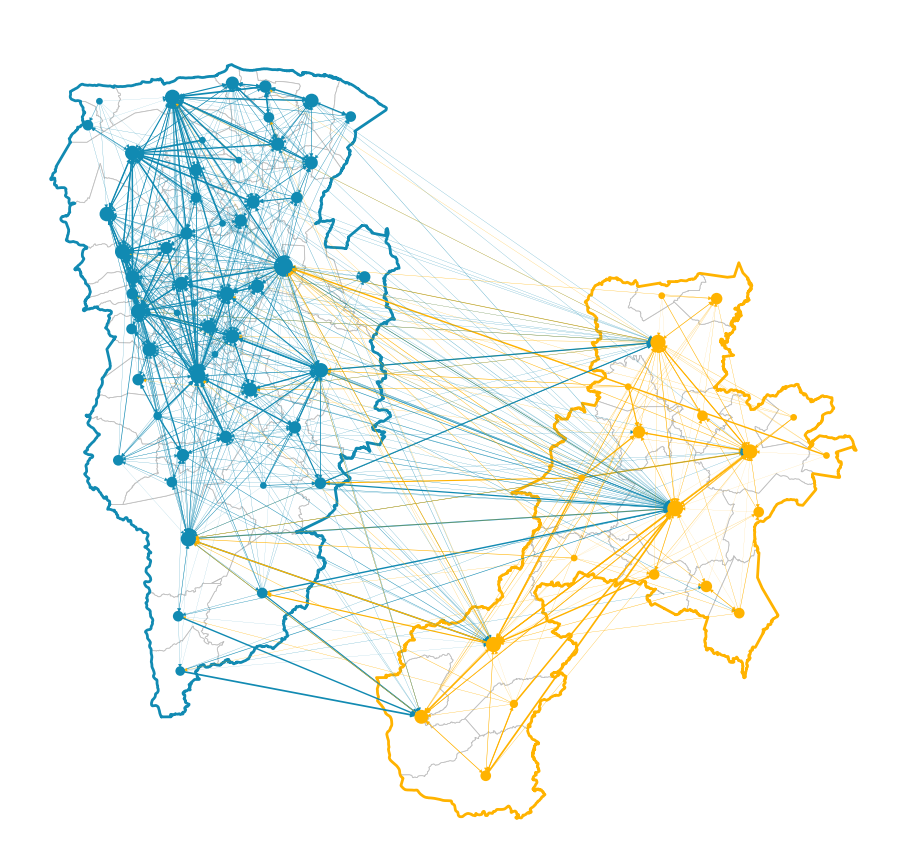

In [175]:
# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(12,11))

mun_macro3 = geodata_df[geodata_df["MACRO_ID"].isin([2])]
macro3 = macro_df[macro_df["MACRO_ID"].isin([2])]

mun_macro4 = geodata_df[geodata_df["MACRO_ID"].isin([4])]#.translate(xoff=0.8, yoff=-1.0)
macro4 = macro_df[macro_df["MACRO_ID"].isin([4])]

mun_macro3_trans = mun_macro3.translate(xoff=+1.1, yoff=+0.2)
macro3_trans = macro3.translate(xoff=+1.1, yoff=+0.2)


mun_macro4.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.6)
mun_macro3_trans.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.6)
macro4.plot(ax=ax1, color="none", edgecolor=macro4["MACRO_COLOR"], linewidth=2.)
macro3_trans.plot(ax=ax1, color="none", edgecolor="#ffb300", linewidth=2.)

nx.draw(G_geo, pos=geopos_net, ax=ax1, arrows=True, arrowsize=6, node_size=in_deg_logrank, node_color=color_nodes, edge_color=edge_colors, width=weight_edge, alpha=1.0, linewidths=2)

In [176]:
fig1.savefig(basepath.joinpath("redes_aih", "doc_final", f"fluxo_example1.png"), dpi=250, bbox_inches='tight')

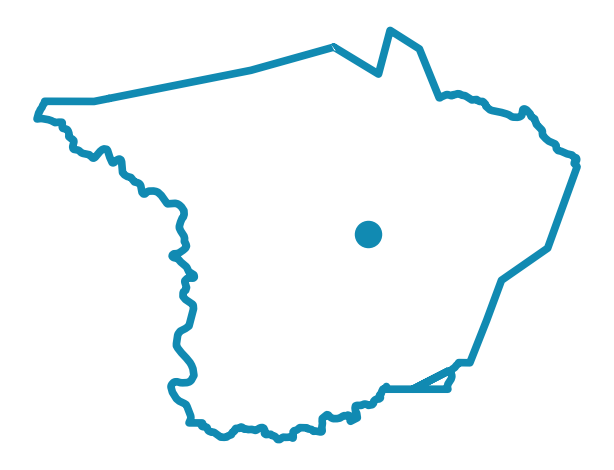

In [161]:
fig, ax = plt.subplots(1)
geodata_df[geodata_df["NM_MUNICIP"]=="CRATEÚS"].plot(ax=ax, color='none', edgecolor="#118ab2", linewidth=5.5)
point = geodata_df[geodata_df["NM_MUNICIP"]=="CRATEÚS"].representative_point()
point.plot(ax=ax, color="#118ab2", markersize=352)
ax.axis('off')
fig.tight_layout()
fig.savefig(basepath.joinpath("redes_aih", "doc_final", f"fluxo_example_crateus.png"), dpi=200, bbox_inches='tight')

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_5468\3478776508.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point = geodata_df[geodata_df["NM_MUNICIP"]=="TAUÁ"].centroid


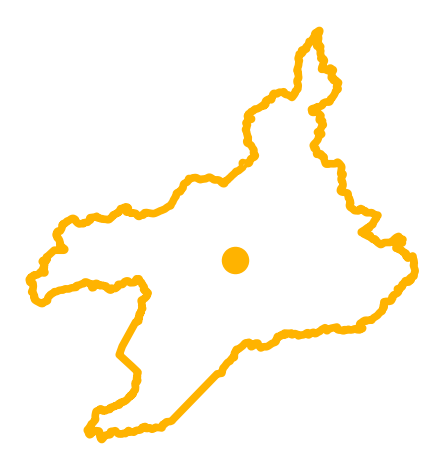

In [162]:
fig, ax = plt.subplots(1)
geodata_df[geodata_df["NM_MUNICIP"]=="TAUÁ"].plot(ax=ax, color='none', edgecolor="#ffb300", linewidth=5.5)
point = geodata_df[geodata_df["NM_MUNICIP"]=="TAUÁ"].centroid
point.plot(ax=ax, color="#ffb300", markersize=352)
ax.axis('off')
fig.tight_layout()
fig.savefig(basepath.joinpath("redes_aih", "doc_final", f"fluxo_example_taua.png"), dpi=200, bbox_inches='tight')

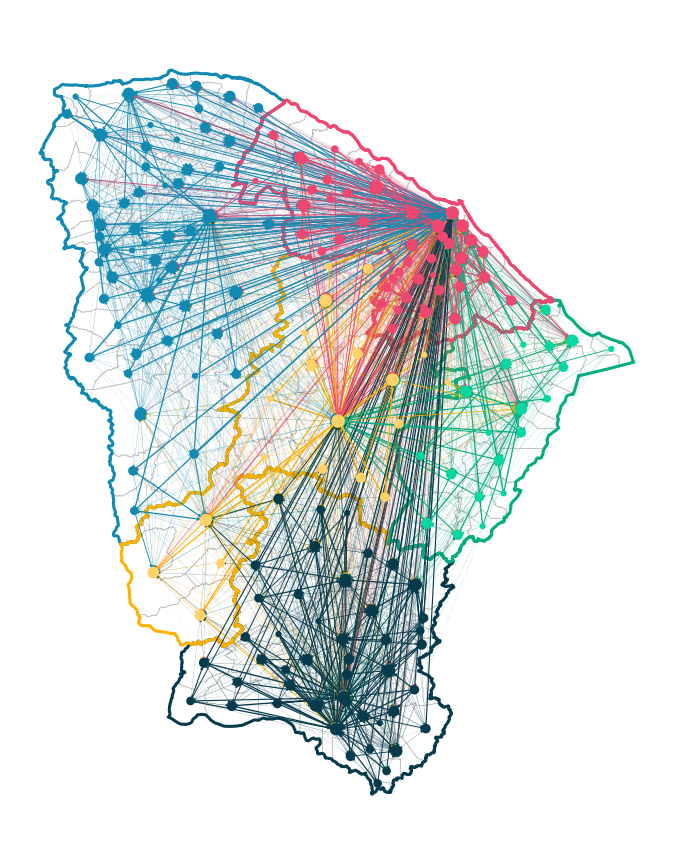

In [29]:
# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(12,11))

geodata_df.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.6)
macro_df.plot(ax=ax1, color="none", edgecolor=macro_df["MACRO_COLOR"], linewidth=2.2)
macro_df[macro_df["MACRO_ID"]==1].plot(ax=ax1, color="none", edgecolor="#ef476f", linewidth=2.2)
ax1.axis('off')
#
nx.draw(G_geo, pos=geopos_net, ax=ax1, arrows=True, arrowsize=4, node_size=in_deg_logrank, node_color=color_nodes, edge_color=edge_colors, width=weight_edge, alpha=1.0, linewidths=2)